In [1]:
import sys
import os
print(os.environ.keys())
sys.path.append(os.environ["BUILD_WORKSPACE_DIRECTORY"])

KeysView(environ({'PYTHONHOME': '/home/nasha_voxelsafety_com/.cache/bazel/_bazel_nasha_voxelsafety_com/3cd1dace9679a4d7a89f2d6e64961b96/external/python_interpreter_3_8_10/opt/python3.8', 'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*.tgz=01;31:*.arc=01;31:*.arj=01;31:*.taz=01;31:*.lha=01;31:*.lz4=01;31:*.lzh=01;31:*.lzma=01;31:*.tlz=01;31:*.txz=01;31:*.tzo=01;31:*.t7z=01;31:*.zip=01;31:*.z=01;31:*.Z=01;31:*.dz=01;31:*.gz=01;31:*.lrz=01;31:*.lz=01;31:*.lzo=01;31:*.xz=01;31:*.zst=01;31:*.tzst=01;31:*.bz2=01;31:*.bz=01;31:*.tbz=01;31:*.tbz2=01;31:*.tz=01;31:*.deb=01;31:*.rpm=01;31:*.jar=01;31:*.war=01;31:*.ear=01;31:*.sar=01;31:*.rar=01;31:*.alz=01;31:*.ace=01;31:*.zoo=01;31:*.cpio=01;31:*.7z=01;31:*.rz=01;31:*.cab=01;31:*.wim=01;31:*.swm=01;31:*.dwm=01;31:*.esd=01;31:*.jpg=01;35:*.jpeg=01;35:*.mjpg=01;35:*.mjpeg=01;35:*.gif=01;35:*.bmp=01;35:*.pbm=

In [2]:
from torch import nn
import torchvision.models as models
import torch
torch.manual_seed(0)
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from datetime import datetime
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import json
import wandb
from torch.utils.data import WeightedRandomSampler
import pandas as pd

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict


def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _,j in dataloader_obj:
        y_idx = j.item()
        y_lbl = idx2class[y_idx]
        count_dict[str(y_lbl)] += 1
            
    return count_dict
def get_class_target_list_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    target = []
    for _,j in dataloader_obj:
        y_idx = j.item()
        target.append(y_idx)
            
    return target

In [5]:
class SelfAttention(nn.Module):
    
    def __init__(self,input_dim):
        super(SelfAttention,self).__init__()
        self.to_query = nn.Conv2d(in_channels = input_dim , out_channels = input_dim//8 , kernel_size= 1)
        self.to_key = nn.Conv2d(in_channels = input_dim , out_channels = input_dim//8 , kernel_size= 1)
        self.to_value = nn.Conv2d(in_channels = input_dim , out_channels = input_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1) #
    
    def forward(self,x):
        bs, c, w, h = x.size()
        Q  = self.to_query(x).view(bs, -1, w * h).permute(0,2,1) 
        K =  self.to_key(x).view(bs,-1,w * h)
        E =  torch.bmm(Q,K) 
        A = self.softmax(E) 
        V = self.to_value(x).view(bs, -1, w * h) 
        Y = torch.bmm(V, A.permute(0,2,1))
        Y = Y.view(bs, c, w, h)
        out = self.gamma * Y + x
        return out, A
    
class AttentionResnet50(nn.Module):
    
    def __init__(self, num_classes):
        super(AttentionResnet50,self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.att_1 = SelfAttention(512)
        self.att_2 = SelfAttention(1024)
        self.att_3 = SelfAttention(2048)
        self.dropout=nn.Dropout(0.2)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self,x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x, _ = self.att_1(x)
        x = self.dropout(x)
        x = self.resnet.layer3(x)
        x, _ = self.att_2(x)
        x = self.dropout(x)
        x = self.resnet.layer4(x)
        x, _ = self.att_3(x)
        x = self.dropout(x)
        x = self.resnet.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.resnet.fc(x)
        return x

In [6]:
def train_init(freeze_layers=True,n_classes=2):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model_conv = torchvision.models.resnet50(pretrained=True)

    for param in model_conv.parameters():
        param.requires_grad = not(freeze_layers)

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, n_classes)

    model_conv = model_conv.to(device)

    criterion = nn.CrossEntropyLoss()

    return model_conv


In [7]:
class MapDataset(Dataset):

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  # image
        y = self.dataset[index][1]   # label      
        return x, y

    def __len__(self):
        return len(self.dataset)

## Focal Loss : https://github.com/kornia/kornia/blob/master/kornia/losses/focal.py

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from typing import Optional

def one_hot(
    labels: torch.Tensor,
    num_classes: int,
    device: Optional[torch.device] = None,
    dtype: Optional[torch.dtype] = None,
    eps: float = 1e-6,
) -> torch.Tensor:
    if not isinstance(labels, torch.Tensor):
        raise TypeError(f"Input labels type is not a torch.Tensor. Got {type(labels)}")

    if not labels.dtype == torch.int64:
        raise ValueError(f"labels must be of the same dtype torch.int64. Got: {labels.dtype}")

    if num_classes < 1:
        raise ValueError("The number of classes must be bigger than one." " Got: {}".format(num_classes))

    shape = labels.shape
    one_hot = torch.zeros((shape[0], num_classes) + shape[1:], device=device, dtype=dtype)

    return one_hot.scatter_(1, labels.unsqueeze(1), 1.0) + eps


def focal_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    alpha: float,
    gamma: float = 2.0,
    reduction: str = 'none',
    eps: Optional[float] = None,
) -> torch.Tensor:
    if eps is not None and not torch.jit.is_scripting():
        warnings.warn(
            "`focal_loss` has been reworked for improved numerical stability "
            "and the `eps` argument is no longer necessary",
            DeprecationWarning,
            stacklevel=2,
        )

    if not isinstance(input, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(input)}")

    if not len(input.shape) >= 2:
        raise ValueError(f"Invalid input shape, we expect BxCx*. Got: {input.shape}")

    if input.size(0) != target.size(0):
        raise ValueError(f'Expected input batch_size ({input.size(0)}) to match target batch_size ({target.size(0)}).')

    n = input.size(0)
    out_size = (n,) + input.size()[2:]
    if target.size()[1:] != input.size()[2:]:
        raise ValueError(f'Expected target size {out_size}, got {target.size()}')

    if not input.device == target.device:
        raise ValueError(f"input and target must be in the same device. Got: {input.device} and {target.device}")

    # compute softmax over the classes axis
    input_soft: torch.Tensor = F.softmax(input, dim=1)
    log_input_soft: torch.Tensor = F.log_softmax(input, dim=1)

    # create the labels one hot tensor
    target_one_hot: torch.Tensor = one_hot(target, num_classes=input.shape[1], device=input.device, dtype=input.dtype)

    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1.0, gamma)

    focal = -alpha * weight * log_input_soft
    loss_tmp = torch.einsum('bc...,bc...->b...', (target_one_hot, focal))

    if reduction == 'none':
        loss = loss_tmp
    elif reduction == 'mean':
        loss = torch.mean(loss_tmp)
    elif reduction == 'sum':
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError(f"Invalid reduction mode: {reduction}")
    return loss

class FocalLoss(nn.Module):

    def __init__(self, alpha: float, gamma: float = 2.0, reduction: str = 'none', eps: Optional[float] = None) -> None:
        super().__init__()
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.reduction: str = reduction
        self.eps: Optional[float] = eps

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return focal_loss(input, target, self.alpha, self.gamma, self.reduction, self.eps)

## Please Change the optimizer learning parameters below

In [9]:


def train_model(model, config, dataloaders, dataset_sizes, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
#     criterion = FocalLoss(alpha = 0.25, gamma = 1.5, reduction = 'mean')
    model_path = '/home/nasha_voxelsafety_com/voxel/experimental/shared/ppe/models'
#     optimizer = torch.optim.Adam([{'params': [param for name, param in model.named_parameters() if 'att' not in name]},
#                               {'params': model.att_1.parameters(), 'lr': 1 * config['learning_rate']}, 
#                               {'params': model.att_2.parameters(), 'lr': 1 * config['learning_rate']}, 
#                               {'params': model.att_3.parameters(), 'lr': 1 * config['learning_rate']}], lr=config['learning_rate'])
    
    wandb.init(project =  "ppe_classification", entity = "voxel-wandb", config = config, tags = [config['tags']])
    config = wandb.config
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=0.1)
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())   
    best_f1 = 0
    model.to(device)
    for epoch in range(config.num_epochs):
        print('Epoch {}/{}'.format(epoch, config.num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_tp = 0
            running_fp = 0
            running_fn = 0
            #running_tn = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).view(-1)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_tp += torch.sum(np.logical_and(preds.cpu(),labels.data.cpu())).cuda()
                running_fp += torch.sum(np.greater(preds.cpu(),labels.data.cpu())).cuda()
                running_fn += torch.sum(np.less(preds.cpu(),labels.data.cpu())).cuda()                

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 

            epoch_precision = running_tp/(running_tp+running_fp)
            epoch_recall = running_tp/(running_tp+running_fn)
            epoch_f1 = 2*(epoch_precision*epoch_recall)/(epoch_precision+epoch_recall)
            if phase == 'val':
                print("val loss", epoch_loss)
                print("val_f1", epoch_f1)
                wandb.log({"val loss":epoch_loss})
                wandb.log({"val_f1":epoch_f1})
            if phase == 'train':
                print("train loss", epoch_loss)
                wandb.log({"train loss":epoch_loss})

            print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc,epoch_precision,epoch_recall, epoch_f1))

            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_f1))


    with open("./best_f1.txt","w") as f:
        f.write(str(float(best_f1)))
    f.close()
    # load best model weights
    model.load_state_dict(best_model_wts)

    #save this model
    example_input = torch.randn(1, 3, 224, 224, requires_grad=False).to(device)
    traced_model = torch.jit.trace(model, example_input)
    today_date = datetime.today().strftime('%Y-%m-%d')
    traced_model.save(f'{model_path}/voxel_vest_classifier_resnet50_{config.tags}_{today_date}.pth')
    wandb.join()
    return model


## Running on dataset V2 Without Samling

In [10]:
data_transforms = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.AutoAugment(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder('/home/nasha_voxelsafety_com/voxel/experimental/shared/data/vestdataset/v2',
transform=data_transforms)
class_names = dataset.classes

In [11]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

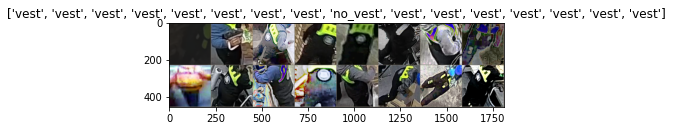

In [16]:

# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:16])

imshow(out, title=[class_names[x] for x in classes[0:16]])

In [17]:
num_val= int(len(dataset) * 0.2)
num_train = len(dataset) - num_val
train, val = random_split(dataset, [num_train, num_val])
batch_size = 128
dataloaders = {
    'train': DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8),
    'val': DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8),
}
dataset_sizes = {}
dataset_sizes['train'] = len(train)
dataset_sizes['val'] = len(val)
print(dataset_sizes)

{'train': 25440, 'val': 6359}


### Define model and optimizer

In [ ]:
# model = AttentionResnet50(2)
model = train_init(freeze_layers=True,n_classes=2)
config = {
        'num_epochs': 30,
        'learning_rate': 1e-2,
        'step':7,
        'tags': "unsample_Focal_V2"
}
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
train_model(model, config, dataloaders, dataset_sizes, optimizer)

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0/29
----------
train loss 0.17653816419202575
train Loss: 0.1765 Acc: 0.9426 Precision: 0.9608 Recall: 0.9777 F1: 0.9692


## Running on dataset V2 With Samling

In [12]:
np.random.seed(0)
data_transforms_2 = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop((224,224),scale=(0.7,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

dataset_2 = datasets.ImageFolder('/home/nasha_voxelsafety_com/voxel/experimental/shared/data/vestdataset/v2')
class_names_2 = dataset_2.classes
num_train = len(dataset_2)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train = torch.utils.data.Subset(dataset_2, train_idx)
val = torch.utils.data.Subset(dataset_2, valid_idx)
train = MapDataset(train, data_transforms_2['train'])
val =  MapDataset(val, data_transforms_2['val'])
dataloaders = {
    'train': DataLoader(train, batch_size=1, shuffle=False, num_workers=8),
    'val': DataLoader(val, batch_size=1, shuffle=False, num_workers=8),
}

In [13]:
dataset_2.class_to_idx
idx2class = {v: k for k, v in dataset_2.class_to_idx.items()}
print(idx2class)

{0: 'no_vest', 1: 'vest'}


In [14]:
class_count =  get_class_distribution(dataset_2)

In [15]:
val_count = get_class_distribution_loaders(dataloaders['val'], dataset_2)

In [16]:
train_count = get_class_distribution_loaders(dataloaders['train'], dataset_2)


Text(0.5, 1.0, 'Val')

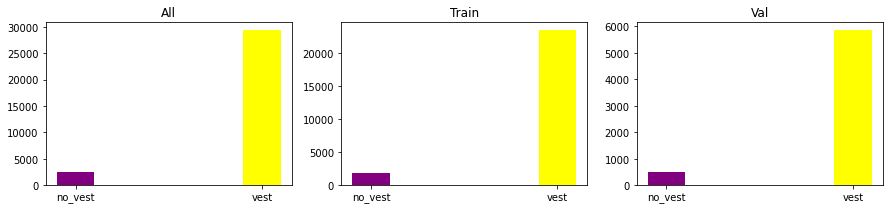

In [17]:
f = plt.figure(figsize=(15,3))
ax0 = f.add_subplot(131)
ax1 = f.add_subplot(132)
ax2 = f.add_subplot(133)
ax0.bar(class_count.keys(), class_count.values(), width = 0.2, color=['purple', 'yellow'])
ax0.set_title("All")
ax1.bar(train_count.keys(), train_count.values(), width = 0.2, color=['purple', 'yellow'])
ax1.set_title("Train")
ax2.bar(val_count.keys(), val_count.values(), width = 0.2, color=['purple', 'yellow'])
ax2.set_title("Val")

### Train Sampler

In [18]:
target_list_train = torch.tensor(get_class_target_list_loaders(dataloaders['train'], dataset_2))
class_count_train = [i for i in get_class_distribution_loaders(dataloaders['train'], dataset_2).values()]
class_weights_train = 1./torch.tensor(class_count_train, dtype=torch.float) 
print(class_weights_train)
class_weights_train_all = class_weights_train[target_list_train]
print(len(class_weights_train_all))


tensor([5.1440e-04, 4.2560e-05])
25440


In [19]:
weighted_sampler_train = WeightedRandomSampler(
    weights=class_weights_train_all,
    num_samples=len(class_weights_train_all),
)

### Val Sampler not needed

In [94]:
target_list_val = torch.tensor(get_class_target_list_loaders(dataloaders['val'], dataset))
print(target_list_val)
class_count_val = [i for i in get_class_distribution_loaders(dataloaders['val'], dataset).values()]
class_weights_val = 1./torch.tensor(class_count_val, dtype=torch.float) 
print(class_weights_val)
class_weights_val_all = class_weights_val[target_list_val]
print(len(class_weights_val_all))
weighted_sampler_val = WeightedRandomSampler(
    weights=class_weights_val_all,
    num_samples=len(class_weights_val_all),
    replacement=True
)

tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([0.0020, 0.0002])
6359


In [20]:
batch_size = 128
dataloaders_sample = {
    'train': DataLoader(train, batch_size=batch_size, num_workers=8, sampler=weighted_sampler_train),
    'val': DataLoader(val, batch_size=batch_size, num_workers=8),
}

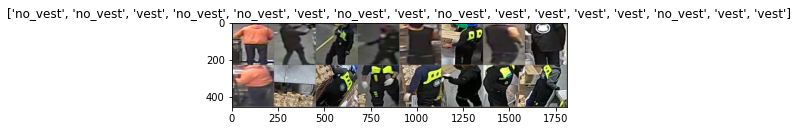

In [22]:
class_names = dataset_2.classes
inputs, classes = next(iter(dataloaders_sample['train']))
out = torchvision.utils.make_grid(inputs[0:16])
imshow(out, title=[class_names[x] for x in classes[0:16]])

In [23]:
dataset_sizes_2 = {}
dataset_sizes_2['train'] = len(train)
dataset_sizes_2['val'] = len(val)
dataset_sizes_2

{'train': 25440, 'val': 6359}

In [ ]:
# model = AttentionResnet50(2)
model_2 = train_init(freeze_layers=True,n_classes=2)
config = {
        'num_epochs': 15,
        'learning_rate': 1e-2,
        'step':7,
        'tags': "sample_vanilla_V2"
}

optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=config['learning_rate'], momentum=0.9)
train_model(model_2, config, dataloaders_sample, dataset_sizes_2, optimizer_2)

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0/14
----------
train loss 0.1679330237818964
train Loss: 0.1679 Acc: 0.9368 Precision: 0.9315 Recall: 0.9424 F1: 0.9369
val loss 0.2909428819013403
val_f1 tensor(0.9339, device='cuda:0')
val Loss: 0.2909 Acc: 0.8855 Precision: 0.9981 Recall: 0.8776 F1: 0.9339
Epoch 1/14
----------
train loss 0.10928534231845688
train Loss: 0.1093 Acc: 0.9599 Precision: 0.9597 Recall: 0.9600 F1: 0.9598
val loss 0.3466977229080292
val_f1 tensor(0.9232, device='cuda:0')
val Loss: 0.3467 Acc: 0.8684 Precision: 0.9990 Recall: 0.8581 F1: 0.9232
Epoch 2/14
----------
